### Lab-II Occlusion Detection
#### Ayush Jamdar EE20B018

- Here, we observe two images taken from different positions at different times.
- The scene is planar.
- We need to align the images properly and then find the difference between the two - in this case, a new object has entered the scene. 

This is how we proceed - 
- find the transformation from `IMG_1` (Source) to `IMG_2` (Target).
$$[x_t, y_t] = R \cdot [x_s, y_s] + [t_x, t_y]$$

$$R = \begin{bmatrix} a & b \\ -b & a\end{bmatrix}$$

- The $R$ matrix contains two variables and the translation vector has two more. Thus, we have four variables. We have been given two pairs of corresponding points. These are enough to solve the problem.

The problem now looks like this - 

$$
\begin{align}

\begin{bmatrix}
x_{s1} & y_{s1} & 1 & 0 \\
x_{s2} & y_{s2} & 1 & 0 \\
y_{s1} & -x_{s1} & 0 & 1 \\
y_{s2} & -x_{s2} & 0 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
a \\
b \\
t_x \\
t_y
\end{bmatrix}
=
\begin{bmatrix}
x_{t1} \\
x_{t2} \\
y_{t1} \\
y_{t2}
\end{bmatrix}


\end{align}
$$

We will call these matrices as - 

$$M \times K = P$$

- Finding the unknowns vector is easy from here. 


In [1]:
import numpy as np
from PIL import Image # for image loading and saving
from IPython.display import display

In [2]:
# Convert a grayscale png/jpg image to a numpy array
# of ints 0 to 256
def image2arr(filename):
    image = Image.open(filename)
    return np.array(image)

# Save a 2D numpy array as an image in jpg/png
def saveArrAsImage(image_array, filepath, file_format):
    image = Image.fromarray(image_array)
    # image.show()
    image.save(filepath, file_format)
    return

# Display a 2D numpy array as an image in the notebook
def display_image(image_array):
    image = Image.fromarray(image_array)
    display(image)

In [3]:
# Bilinear Interpolation for Target to Source Mapping.  
def bilinear_interpolation(xs, ys, xt, yt, target_array, source_array):
    xs_flr = int(np.floor(xs))
    ys_flr = int(np.floor(ys))

    if (0 <= xs < source_array.shape[0] - 1) and (
        0 <= ys < source_array.shape[1] - 1
    ):
        a = xs - xs_flr
        b = ys - ys_flr
        target_array[xt, yt] = (
            (1 - a) * (1 - b) * source_array[xs_flr, ys_flr]
            + (1 - a) * b * source_array[xs_flr, ys_flr + 1]
            + a * (1 - b) * source_array[xs_flr + 1, ys_flr]
            + a * b * source_array[xs_flr + 1, ys_flr + 1]
        )

    return

Now use the given points of correspondence here. 
The matrices explained earlier shall be named as -

$$M \times K = P$$

In [4]:
source_points = [(29, 124), (157, 372)]
target_points = [(93, 248), (328, 399)]

M = np.array([[source_points[0][0], source_points[0][1], 1, 0], 
              [source_points[1][0], source_points[1][1], 1, 0],
              [source_points[0][1], -source_points[0][0], 0, 1],
              [source_points[1][1], -source_points[1][0], 0, 1]])

P = np.array([target_points[0][0],
              target_points[1][0],
              target_points[0][1],
              target_points[1][1]])

K = np.matmul(np.linalg.inv(M), P)
(a, b, t_x, t_y) = K

R = np.array([[a, b], [-b, a]])

In [11]:
R

array([[ 0.8669885 ,  0.50010271],
       [-0.50010271,  0.8669885 ]])

Let us see what the images are.

Image-1:


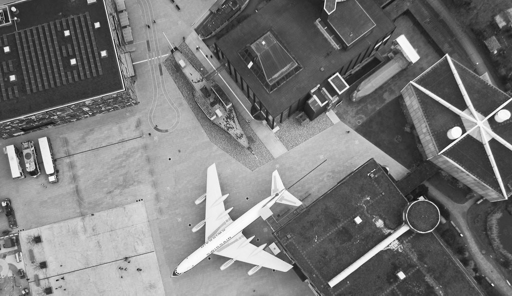

Image-2:


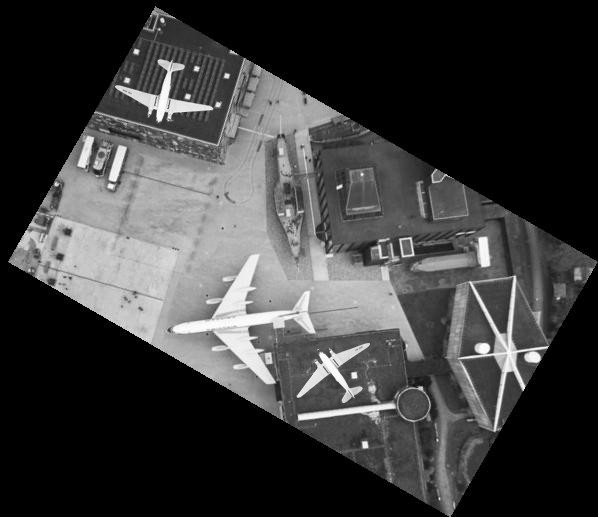

In [5]:
source_image_mat = image2arr("IMG1.png")
target_image_mat = image2arr("IMG2.png")

print("Image-1:")
display_image(source_image_mat)

print("Image-2:")
display_image(target_image_mat)

Now that we know the transformation parameters, we can un-transform the target image to make it look like the source.

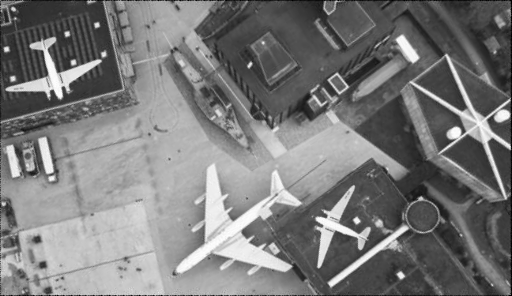

In [6]:
source_image_mat = image2arr("IMG1.png")
target_image_mat = image2arr("IMG2.png")

untransformed_target = np.zeros(source_image_mat.shape).astype(np.uint8)

for i in range(untransformed_target.shape[0]):
    for j in range(untransformed_target.shape[1]):
        (xt, yt) = np.matmul(R, np.array([i, j])) + np.array((t_x, t_y))
        bilinear_interpolation(xt, yt, i, j, untransformed_target, target_image_mat)

display_image(untransformed_target)
saveArrAsImage(untransformed_target, "aligned_img2.png", "PNG")

Now that we have aligned the images, calculating the difference is easy. We use a plain rule that wherever the difference between pixel intensities of the two images is greater than a threshold, make that pixel white and keep the rest dark.

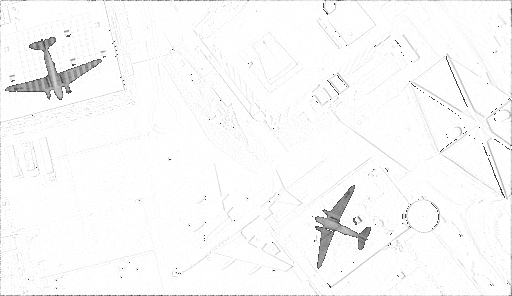

In [17]:
# difference_img_mat = np.zeros(source_image_mat.shape).astype(np.uint8) 

diff_thresh = 50
difference_img_mat = untransformed_target - source_image_mat
difference_img_mat[np.where(untransformed_target - source_image_mat < diff_thresh)] = 255
display_image(difference_img_mat)
saveArrAsImage(difference_img_mat, "difference.png", "PNG")

Observe that the two planes are clearly visible as to being stark additions marked by a white aircraft-shaped patch. 

Also, there are a lot more white pixels in the scene that indicate a difference between the two images. This is due to the slight differences that arise during the inverse transform. 

So we may conclude that the two airplanes are an addition in `IMG1` with respect to `IMG2`. 